# Evaluation process

# Phase I

In [1]:
#Importing libraries
import os
import torch
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, average_precision_score
from sklearn.linear_model import LogisticRegression as lr_model
import joblib
from pytrial.data.trial_data import TrialOutcomeDatasetBase
from pytrial.tasks.trial_outcome.data import TrialOutcomeDataset
import pandas as pd
import matplotlib.pyplot as plt 
from torch.utils.data.dataloader import default_collate
from pytrial.tasks.trial_outcome import LogisticRegression, MLP, XGBoost, HINT, SPOT
from torch.utils.data import DataLoader
from pytrial.tasks.trial_outcome.model_utils.dataloader import Trial_Dataset_Complete,trial_collate_fn,csv_three_feature_2_dataloader
from torch.utils.data.dataloader import default_collate
from pytrial.tasks.trial_outcome.base import TrialOutcomeBase
import numpy as np
import networkx as nx
import numpy as np
from torch_geometric.utils import to_networkx
%matplotlib inline
import matplotlib.pyplot as plt

from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module 
from captum.attr import Saliency, IntegratedGradients
import torch

## Testing models prediction using Captum

In [2]:
import torch, os, sys
sys.path.append('.')
from HINT.dataloader_enrollment import csv_three_feature_2_dataloader, generate_admet_dataloader_lst, csv_three_feature_2_complete_dataloader
from HINT.molecule_encode import MPNN 
from HINT.icdcode_encode import GRAM, build_icdcode2ancestor_dict
from HINT.protocol_encode import Protocol_Embedding
from HINT.model_experiment_enrollment import Interaction, HINT_nograph, HINTModel,Highway,GCN,GAT
from HINT.model_experiment_enrollment import ADMET

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if not os.path.exists("figure"):
	os.makedirs("figure")


## 2. data
base_name = 'phase_III' 
# base_name = "toy" 
datafolder = "data"
train_file = os.path.join(datafolder, base_name + '_train_enr.csv')
valid_file = os.path.join(datafolder, base_name + '_valid_enr.csv')
test_file = os.path.join(datafolder, base_name + '_test_enr.csv')

print(len(train_file))
print(len(valid_file))
print(len(test_file))


## 4. dataloader, model build, train, inference
train_loader = csv_three_feature_2_dataloader(train_file, shuffle=True, batch_size=32) 
valid_loader = csv_three_feature_2_dataloader(valid_file, shuffle=False, batch_size=32) 
test_loader = csv_three_feature_2_dataloader(test_file, shuffle=False, batch_size=32) 

icdcode2ancestor_dict = build_icdcode2ancestor_dict()
gram_model = GRAM(embedding_dim = 50, icdcode2ancestor = icdcode2ancestor_dict, device = device)
protocol_model = Protocol_Embedding(output_dim = 50, highway_num=3, device = device)


hint_model_path = "save_model/" + base_name + ".ckpt"
if not os.path.exists(hint_model_path):

	## 3. pretrain 
	mpnn_model = MPNN(mpnn_hidden_size = 50, mpnn_depth=3, device = device)
	admet_model_path = "save_model/admet_model.ckpt"
	if not os.path.exists(admet_model_path):
		admet_dataloader_lst = generate_admet_dataloader_lst(batch_size=32)
		admet_trainloader_lst = [i[0] for i in admet_dataloader_lst]
		admet_testloader_lst = [i[1] for i in admet_dataloader_lst]
		admet_model = ADMET(molecule_encoder = mpnn_model, 
							highway_num=2, 
							device = device, 
							epoch=3, 
							lr=5e-4, 
							weight_decay=0, 
							save_name = 'admet_')
		admet_model.train(admet_trainloader_lst, admet_testloader_lst)
		torch.save(admet_model, admet_model_path)
		print('OK ADMET')
	else:
		admet_model = torch.load(admet_model_path)
		admet_model = admet_model.to(device)
		admet_model.set_device(device)
		print('ko ADMET')


	model = HINTModel(molecule_encoder = mpnn_model, 
			 disease_encoder = gram_model, 
			 protocol_encoder = protocol_model,
			 device = device, 
			 global_embed_size = 50, 
			 highway_num_layer = 2,
			 prefix_name = base_name, 
			 gnn_hidden_size = 50,  
			 epoch = 5,
			 lr = 1e-3, 
			 weight_decay = 0, 
			)
	model.init_pretrain(admet_model)
	model.learn(train_loader, valid_loader, test_loader)
	model.generate_predict(test_loader)
	torch.save(model, hint_model_path)
	print("OK MODEL")
else:
	model = torch.load(hint_model_path,weights_only=False)
	torch.save(model, hint_model_path)
	print ("KO")

| Uniform Initialization
| Uniform Initialization
28
28
27
| Uniform Initialization
| Uniform Initialization
ko ADMET
| Uniform Initialization
| Uniform Initialization


100%|██████████████████████████████████████████████████████████████████████████| 5/5 [28:13<00:00, 338.74s/it]


ROC AUC: 0.768
F1: 0.837
PR-AUC: 0.794
Precision: 0.804
Recall: 0.873
Accuracy: 0.756
Predict 1 ratio: 0.781
Label 1 ratio: 0.720
OK MODEL


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv

class GAT(torch.nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout, alpha, nheads):
        super(GAT, self).__init__()
        self.dropout = dropout
        self.attentions = GATConv(nfeat, nhid, heads=nheads, dropout=dropout)
        self.out_att = GATConv(nhid * nheads, nclass, heads=1, concat=False, dropout=dropout)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.attentions(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.out_att(x, edge_index)
        return F.log_softmax(x, dim=1)

class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()
        self.gc1 = GCNConv(nfeat, nhid)
        self.gc2 = GCNConv(nhid, nclass)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.relu(self.gc1(x, edge_index))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, edge_index)
        return x

class HINTModel(nn.Module):
    def __init__(self, molecule_encoder, disease_encoder, protocol_encoder, device, global_embed_size, highway_num_layer, prefix_name, gnn_hidden_size, epoch=20, lr=3e-4, weight_decay=0):
        super(HINTModel, self).__init__()
        self.device = device
        self.global_embed_size = global_embed_size
        self.highway_num_layer = highway_num_layer
        self.gnn_hidden_size = gnn_hidden_size
        self.adj, self.edge_index = self.generate_adj()
        self.gnn = GCN(nfeat=global_embed_size, nhid=gnn_hidden_size, nclass=1, dropout=0.6)
        self.node_size = self.adj.shape[0]
        self.graph_attention_model_mat = nn.ModuleList([
            nn.ModuleList([self.gnn_attention() if self.adj[i, j] == 1 else None for j in range(self.node_size)]) for i in range(self.node_size)
        ])
        self = self.to(device)

    def generate_adj(self):        								
        lst = ["molecule", "disease", "enrollment", "criteria", 'INTERACTION', 'risk_disease', 
               'augment_interaction', 'A', 'D', 'M', 'E', 'T', 'PK', "final"]
        edge_lst = [("disease", "molecule"), ("disease", "criteria"), ("molecule", "criteria"), 
                    ("disease", "INTERACTION"), ("molecule", "INTERACTION"), ("criteria", "INTERACTION"), 
                    ("disease", "risk_disease"), ('risk_disease', 'augment_interaction'), ('INTERACTION', 'augment_interaction'),
                    ("molecule", "A"), ("molecule", "D"), ("molecule", "M"), ("molecule", "E"), ("molecule", "T"),
                    ('A', 'PK'), ('D', 'PK'), ('M', 'PK'), ('E', 'PK'), ('T', 'PK'), 
                    ('augment_interaction', 'final'), ('PK', 'final'), ('enrollment','criteria'), ('enrollment','INTERACTION')]
        adj = torch.zeros(len(lst), len(lst))
        adj = torch.eye(len(lst)) * len(lst)
        num2str = {k: v for k, v in enumerate(lst)}
        str2num = {v: k for k, v in enumerate(lst)}
        for i, j in edge_lst:
            n1, n2 = str2num[i], str2num[j]
            adj[n1, n2] = 1
            adj[n2, n1] = 1
        return adj.to(self.device)

    def generate_attention_matrx(self, node_feature_mat):
        #print(f"self.node_size: {self.node_size}")
        #print(f"node_feature_mat.shape: {node_feature_mat.shape}")
        #print(f"self.adj.shape: {self.adj.shape}")
        attention_mat = torch.zeros(self.node_size, self.node_size).to(self.device)
        for i in range(self.node_size):
            for j in range(self.node_size):
                if self.adj[i, j] != 1:
                    continue 
                feature = torch.cat([node_feature_mat[i].view(1, -1), node_feature_mat[j].view(1, -1)], 1)
                attention_model = self.graph_attention_model_mat[i][j]
                attention_mat[i, j] = torch.sigmoid(self.feed_lst_of_module(input_feature=feature, lst_of_module=attention_model))
        return attention_mat 

    def gnn_attention(self):
        highway_nn = Highway(size=self.global_embed_size * 2, num_layers=self.highway_num_layer).to(self.device)
        highway_fc = nn.Linear(self.global_embed_size * 2, 1).to(self.device)
        return nn.ModuleList([highway_nn, highway_fc])

    def forward(self, smiles_lst2, icdcode_lst3, criteria_lst, enrollment_lst, return_attention_matrix=False):
        # Get embeddings from the parent class
        embedding_lst = HINT_nograph.forward(self, smiles_lst2, icdcode_lst3, criteria_lst, enrollment_lst, if_gnn=True)
        
        batch_size = embedding_lst[0].shape[0]
        output_lst = []
        if return_attention_matrix:
            attention_mat_lst = []

        for i in range(batch_size):
            # Include enrollment in node features
            node_feature_lst = [embedding[i].view(1, -1) for embedding in embedding_lst]
            node_feature_mat = torch.cat(node_feature_lst, 0)
            attention_mat = self.generate_attention_matrx(node_feature_mat)

            output = self.gnn(node_feature_mat, self.adj * attention_mat)
            output = output[-1].view(1, -1)
            output_lst.append(output)

            if return_attention_matrix:
                attention_mat_lst.append(attention_mat)

        output_mat = torch.cat(output_lst, 0)

        if not return_attention_matrix:
            return output_mat
        else:
            return output_mat, attention_mat_lst

Variabili che alimentano il modello GAT.
1. x: La matrice degli embedding dei nodi, calcolata tramite un encoder o una funzione forward in un modello precedente.

### Modello 

In [4]:
HINT_nograph = HINT_nograph(molecule_encoder = mpnn_model, 
			 disease_encoder = gram_model, 
			 protocol_encoder = protocol_model,
			 device = 'cuda', 
			 global_embed_size = 50, 
			 highway_num_layer = 2,
    prefix_name="GAT"
)

### La matrice degli embedding dei nodi

In [5]:
# Extract data from the dataloader
nctid_lst, label_lst, smiles_lst2, icdcode_lst3, criteria_lst, enrollment_lst, length = HINT_nograph.testloader_to_lst(test_loader)

In [6]:
embedding_lst = HINT_nograph.forward(smiles_lst2, icdcode_lst3, criteria_lst,enrollment_lst, if_gnn=True)
embedding_lst #A list of tensors, where each tensor is a 2D array of embeddings.

[tensor([[1.3911e-01, 9.1704e-04, 0.0000e+00,  ..., 1.6310e-01, 1.3899e-02,
          5.3631e-03],
         [7.3782e-02, 0.0000e+00, 5.9077e-02,  ..., 1.0202e-01, 1.1204e-03,
          6.8397e-03],
         [1.3602e-01, 1.1660e-03, 3.5314e-03,  ..., 1.7209e-01, 1.0670e-02,
          3.0424e-03],
         ...,
         [4.7921e-02, 2.2462e-03, 2.0413e-04,  ..., 2.3277e-01, 3.2880e-02,
          2.2705e-03],
         [1.6806e-01, 2.4910e-03, 1.2362e-02,  ..., 1.7974e-01, 8.4304e-03,
          1.9766e-03],
         [1.0620e-01, 0.0000e+00, 5.9167e-03,  ..., 2.1810e-01, 2.3745e-02,
          6.4616e-03]], device='cuda:0', grad_fn=<CatBackward0>),
 tensor([[-0.8573,  0.4153, -0.3563,  ...,  0.2492,  0.1524,  0.0976],
         [-0.3487, -0.1387,  0.3124,  ..., -0.2080,  0.4105,  0.4777],
         [-0.1029,  0.1797,  0.1330,  ..., -1.7000,  0.6048,  0.1666],
         ...,
         [-0.2627, -0.0318,  0.0173,  ...,  0.3457, -0.3144,  0.1354],
         [-0.5720, -0.0333,  0.2151,  ..., -0.2388,

In [7]:
for i, embedding in enumerate(embedding_lst):
    print(f"Embedding {i}: {embedding.shape}") #for 664 nodes, with 50 features per node.

Embedding 0: torch.Size([1133, 50])
Embedding 1: torch.Size([1133, 50])
Embedding 2: torch.Size([1133, 50])
Embedding 3: torch.Size([1133, 50])
Embedding 4: torch.Size([1133, 50])
Embedding 5: torch.Size([1133, 50])
Embedding 6: torch.Size([1133, 50])
Embedding 7: torch.Size([1133, 50])
Embedding 8: torch.Size([1133, 50])
Embedding 9: torch.Size([1133, 50])
Embedding 10: torch.Size([1133, 50])
Embedding 11: torch.Size([1133, 50])
Embedding 12: torch.Size([1133, 50])
Embedding 13: torch.Size([1133, 50])


Calcolo aggregato per x:

In [8]:
node_feature_mat = torch.cat([embedding.view(1, -1) for embedding in embedding_lst], 0) #Concatenates the list of tensors along the first dimension (dim=0).
node_feature_mat

tensor([[ 0.1391,  0.0009,  0.0000,  ...,  0.2181,  0.0237,  0.0065],
        [-0.8573,  0.4153, -0.3563,  ..., -0.5211,  0.6155,  0.0666],
        [ 0.0626,  0.0540,  0.0000,  ...,  0.0000,  0.0501,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0771,  0.0000,  0.0121],
        [ 0.0000,  0.0390,  0.0260,  ...,  0.0575,  0.0438,  0.0493],
        [ 0.0000,  0.0692,  0.0573,  ...,  0.0708,  0.0844,  0.0198]],
       device='cuda:0', grad_fn=<CatBackward0>)

In [9]:
print("x Shape:", node_feature_mat.shape)
print("x Mean:", node_feature_mat.mean())
print("x Std Dev:", node_feature_mat.std())

x Shape: torch.Size([14, 56650])
x Mean: tensor(0.0189, device='cuda:0', grad_fn=<MeanBackward0>)
x Std Dev: tensor(173.3903, device='cuda:0', grad_fn=<StdBackward0>)


In [10]:
for i, embedding in enumerate(node_feature_mat):
    print(f"Embedding {i}: {embedding.shape}")

Embedding 0: torch.Size([56650])
Embedding 1: torch.Size([56650])
Embedding 2: torch.Size([56650])
Embedding 3: torch.Size([56650])
Embedding 4: torch.Size([56650])
Embedding 5: torch.Size([56650])
Embedding 6: torch.Size([56650])
Embedding 7: torch.Size([56650])
Embedding 8: torch.Size([56650])
Embedding 9: torch.Size([56650])
Embedding 10: torch.Size([56650])
Embedding 11: torch.Size([56650])
Embedding 12: torch.Size([56650])
Embedding 13: torch.Size([56650])


The resulting node_feature_mat contains combined features from all embeddings for the same node.

**edge_index**\
Definizione: Gli indici degli edge sono creati a partire dalla struttura del grafo.

In [11]:
model = HINTModel(
    molecule_encoder=mpnn_model,
    disease_encoder=gram_model,
    protocol_encoder=protocol_model,
    device='cuda',
    global_embed_size=50,
    highway_num_layer=2,
    prefix_name="base_name",
    gnn_hidden_size=50,
    epoch=5,
    lr=1e-3,
    weight_decay=0
)



| Uniform Initialization
| Uniform Initialization


In [12]:
def generate_adj(self):                                
    """
    Generates the adjacency matrix and edge_index for the graph.
    """
    lst = [
        "molecule", "disease", "enrollment", "criteria", 'INTERACTION', 
        'risk_disease', 'augment_interaction', 'A', 'D', 'M', 'E', 'T', 
        'PK', "final"
    ]
    edge_lst = [
        ("disease", "molecule"), ("disease", "criteria"), ("molecule", "criteria"),
        ("disease", "INTERACTION"), ("molecule", "INTERACTION"), ("criteria", "INTERACTION"),
        ("disease", "risk_disease"), ('risk_disease', 'augment_interaction'), 
        ('INTERACTION', 'augment_interaction'), ("molecule", "A"), 
        ("molecule", "D"), ("molecule", "M"), ("molecule", "E"), ("molecule", "T"),
        ('A', 'PK'), ('D', 'PK'), ('M', 'PK'), ('E', 'PK'), ('T', 'PK'),
        ('augment_interaction', 'final'), ('PK', 'final'), 
        ('enrollment', 'criteria'), ('enrollment', 'INTERACTION')
    ]
    
    # Initialize adjacency matrix
    adj = torch.zeros(len(lst), len(lst))
    adj = torch.eye(len(lst)) * len(lst)
    
    # Create mappings
    num2str = {k: v for k, v in enumerate(lst)}
    str2num = {v: k for k, v in enumerate(lst)}
    # Populate adjacency matrix
    for i, j in edge_lst:
        n1, n2 = str2num[i], str2num[j]
        adj[n1, n2] = 1
        adj[n2, n1] = 1

    # Derive edge_index from adjacency matrix
    adj = adj.to(self.device)
    print(f"Adjacency matrix shape: {adj.shape}")
    return adj

In [13]:
adj = model.generate_adj()
adj

tensor([[14.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  0.],
        [ 1., 14.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., 14.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  1.,  1., 14.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  1.,  1.,  1., 14.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0., 14.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  1., 14.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0., 14.,  0.,  0.,  0.,  0.,  1.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 14.,  0.,  0.,  0.,  1.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 14.,  0.,  0.,  1.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 14.,  0.,  1.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 14.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  

In [14]:
edge_index = torch.stack(adj.nonzero(as_tuple=True), dim=0).long()
edge_index

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  3,
          3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  5,  5,  5,  6,  6,  6,  6,  7,
          7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11, 11, 11, 12, 12, 12, 12,
         12, 12, 12, 13, 13, 13],
        [ 0,  1,  3,  4,  7,  8,  9, 10, 11,  0,  1,  3,  4,  5,  2,  3,  4,  0,
          1,  2,  3,  4,  0,  1,  2,  3,  4,  6,  1,  5,  6,  4,  5,  6, 13,  0,
          7, 12,  0,  8, 12,  0,  9, 12,  0, 10, 12,  0, 11, 12,  7,  8,  9, 10,
         11, 12, 13,  6, 12, 13]], device='cuda:0')

In [15]:
edge_index.shape

torch.Size([2, 60])

In [16]:
print("Max Node Index in edge_index:", edge_index.max().item())

Max Node Index in edge_index: 13


In [17]:
edge_index = torch.stack(adj.nonzero(as_tuple=True), dim=0).long()
print(edge_index) # Source nodes and target nodes

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  3,
          3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  5,  5,  5,  6,  6,  6,  6,  7,
          7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11, 11, 11, 12, 12, 12, 12,
         12, 12, 12, 13, 13, 13],
        [ 0,  1,  3,  4,  7,  8,  9, 10, 11,  0,  1,  3,  4,  5,  2,  3,  4,  0,
          1,  2,  3,  4,  0,  1,  2,  3,  4,  6,  1,  5,  6,  4,  5,  6, 13,  0,
          7, 12,  0,  8, 12,  0,  9, 12,  0, 10, 12,  0, 11, 12,  7,  8,  9, 10,
         11, 12, 13,  6, 12, 13]], device='cuda:0')


In [18]:
print("Edge Index Shape:", edge_index.shape) #[2, num_edges]
print("Node Count (from node_feature_mat):", node_feature_mat.size(0)) #[num_nodes, num_features]
print("Max Node Index in edge_index:", edge_index.max().item())


Edge Index Shape: torch.Size([2, 60])
Node Count (from node_feature_mat): 14
Max Node Index in edge_index: 13


In [19]:
unique_nodes = torch.unique(edge_index)
num_nodes = torch.unique(node_feature_mat)
print(f"Unique Nodes: {unique_nodes,num_nodes}")
print(f"Node Count: {len(unique_nodes)}")
print(f"node_feature_mat shape: {node_feature_mat.shape}")


Unique Nodes: (tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
       device='cuda:0'), tensor([-18277.0605, -17946.1094, -16622.7383,  ...,  16887.7402,
         19027.2949,  19181.5762], device='cuda:0', grad_fn=<Unique2Backward0>))
Node Count: 14
node_feature_mat shape: torch.Size([14, 56650])


## Initiate

In [20]:
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from captum.attr import IntegratedGradients, Saliency
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt

# Step 1: Node Features
x = torch.tensor(node_feature_mat, dtype=torch.float)

# Step 2: Edge Index
lst = ["molecule", "disease", "enrollment", "criteria", 'interaction', 'risk_disease', 
               'augment_interaction', 'A', 'D', 'M', 'E', 'T', 'PK', "final"]
edge_lst = [("disease", "molecule"), ("disease", "criteria"), ("molecule", "criteria"), 
                    ("disease", "interaction"), ("molecule", "interaction"), ("criteria", "interaction"), 
                    ("disease", "risk_disease"), ('risk_disease', 'augment_interaction'), ('interaction', 'augment_interaction'),
                    ("molecule", "A"), ("molecule", "D"), ("molecule", "M"), ("molecule", "E"), ("molecule", "T"),
                    ('A', 'PK'), ('D', 'PK'), ('M', 'PK'), ('E', 'PK'), ('T', 'PK'), 
                    ('augment_interaction', 'final'), ('PK', 'final'), ('enrollment','criteria'), ('enrollment','interaction')]
edge_index = torch.tensor([[lst.index(src), lst.index(tgt)] for src, tgt in edge_lst] +
                          [[lst.index(tgt), lst.index(src)] for src, tgt in edge_lst]).T.long()

# Step 3: Labels
num_nodes = x.size(0)
y = torch.randint(0, 2, (num_nodes,)).float()


# Step 4: Masks
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
labeled_nodes = int(0.6 * num_nodes) + int(0.2 * num_nodes)
train_mask[:int(0.6 * labeled_nodes)] = True
val_mask[int(0.6 * labeled_nodes):int(0.8 * labeled_nodes)] = True
test_mask[int(0.8 * labeled_nodes):labeled_nodes] = True

# PyTorch Geometric Data Object
data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

# Step 5: Define Models
nfeat = data.x.shape[1]
nhid = 32
dropout = 0.6

gcn_model = GCN(nfeat=nfeat, nhid=nhid, nclass=1, dropout=dropout).to(device)
gat_model = GAT(nfeat=nfeat, nhid=nhid, nclass=1, dropout=dropout, alpha=0.2, nheads=4).to(device)

# Define binary loss and optimizer
criterion = torch.nn.BCEWithLogitsLoss()
optimizer_gcn = torch.optim.Adam(gcn_model.parameters(), lr=0.001, weight_decay=5e-4)
optimizer_gat = torch.optim.Adam(gat_model.parameters(), lr=0.001, weight_decay=5e-4)


## GCN

In [21]:
# GCN Model
class GCN(torch.nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()
        self.gc1 = GCNConv(nfeat, nhid)
        self.gc2 = GCNConv(nhid, 1)
        self.dropout = dropout

    def forward(self, x, edge_index, edge_weight=None):
        x = F.relu(self.gc1(x, edge_index, edge_weight=edge_weight))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, edge_index, edge_weight=edge_weight).squeeze()
        return x

# Training Loop
gcn_model = GCN(nfeat=x.size(1), nhid=32, nclass=1, dropout=0.65).to(device)
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01, weight_decay=1e-3)
criterion = torch.nn.BCEWithLogitsLoss()

def train():
    gcn_model.train()
    optimizer.zero_grad()
    out = gcn_model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    gcn_model.eval()
    out = gcn_model(data.x, data.edge_index)
    pred = (torch.sigmoid(out) > 0.5).long()

    def accuracy(mask):
        return (pred[mask] == data.y[mask]).sum().item() / mask.sum().item()

    return accuracy(data.train_mask), accuracy(data.val_mask), accuracy(data.test_mask)

for epoch in range(200):
    loss = train()
    train_acc, val_acc, test_acc = test()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")

Epoch 0, Loss: 38.1206, Train Acc: 0.8333, Val Acc: 1.0000, Test Acc: 1.0000
Epoch 10, Loss: 1203.7498, Train Acc: 0.8333, Val Acc: 0.5000, Test Acc: 0.0000
Epoch 20, Loss: 8241.3750, Train Acc: 0.8333, Val Acc: 1.0000, Test Acc: 1.0000
Epoch 30, Loss: 1767.1859, Train Acc: 0.8333, Val Acc: 1.0000, Test Acc: 1.0000
Epoch 40, Loss: 711.9426, Train Acc: 0.8333, Val Acc: 0.5000, Test Acc: 0.0000
Epoch 50, Loss: 76.3318, Train Acc: 0.8333, Val Acc: 0.5000, Test Acc: 0.0000
Epoch 60, Loss: 11.6289, Train Acc: 0.6667, Val Acc: 0.5000, Test Acc: 0.0000
Epoch 70, Loss: 245.0331, Train Acc: 0.8333, Val Acc: 1.0000, Test Acc: 1.0000
Epoch 80, Loss: 381.5770, Train Acc: 0.8333, Val Acc: 1.0000, Test Acc: 1.0000
Epoch 90, Loss: 337.1703, Train Acc: 0.8333, Val Acc: 1.0000, Test Acc: 1.0000
Epoch 100, Loss: 281.4597, Train Acc: 0.8333, Val Acc: 1.0000, Test Acc: 1.0000
Epoch 110, Loss: 200.5479, Train Acc: 0.6667, Val Acc: 0.5000, Test Acc: 0.0000
Epoch 120, Loss: 71.1218, Train Acc: 0.8333, Val Ac

## Explaining Predictions

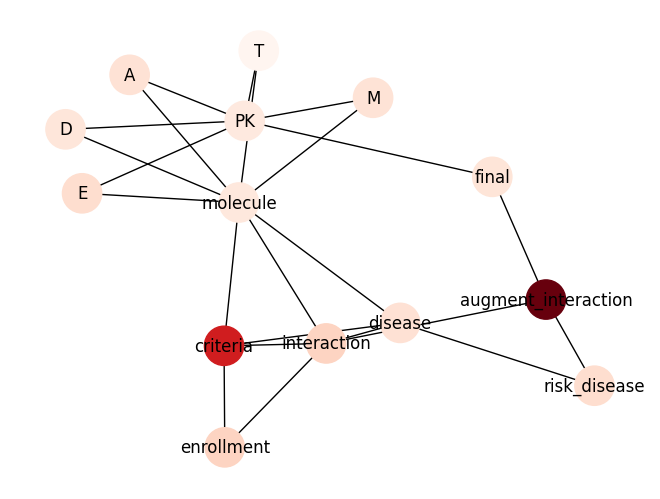

{'molecule': -0.10715782106681054, 'disease': -0.06274077887386885, 'enrollment': -0.003339450248260731, 'criteria': 0.6790989609774866, 'interaction': -0.00619577801444461, 'risk_disease': -0.041434065175883106, 'augment_interaction': 1.0, 'A': -0.0635061532274023, 'D': -0.09596096007610483, 'M': -0.07038360332330398, 'E': -0.04186705109322389, 'T': -0.20445442078387013, 'PK': -0.11532245843115838, 'final': -0.08582562562749584}


In [22]:
def model_forward(node_features, data):
    """
    Forward function for Captum.
    Applies node features as input and calculates probabilities.
    """
    logits = gcn_model(node_features, data.edge_index)  # Forward pass
    probabilities = torch.stack([1 - torch.sigmoid(logits), torch.sigmoid(logits)], dim=-1)  # Probabilities
    return probabilities


from captum.attr import IntegratedGradients

# Integrated Gradients
ig = IntegratedGradients(model_forward)

# Calcolare l'importanza delle feature dei nodi
attr = ig.attribute(inputs=data.x,  # Feature dei nodi
                    target=1,  # Target class
                    additional_forward_args=(data,),  # Dati aggiuntivi per il modello
                    internal_batch_size=data.x.size(0))  # Batch size

# Somma delle attribuzioni per ogni nodo
node_importance = attr.sum(dim=1).cpu().detach().numpy()

# Normalizzare i valori (opzionale)
if node_importance.max() > 0:
    node_importance = node_importance / node_importance.max()

# Mappa nodo-importanza
node_importance_dict = {lst[i]: importance for i, importance in enumerate(node_importance)}

def visualize_node_importance(node_importance, data):
    """
    Visualize the graph with node importance highlighted.
    """
    G = nx.Graph()
    for (u, v) in data.edge_index.cpu().numpy().T:
        G.add_edge(lst[u], lst[v])

    # Aggiungi importanza dei nodi come attributo
    nx.set_node_attributes(G, {lst[i]: importance for i, importance in enumerate(node_importance)}, 'importance')

    pos = nx.spring_layout(G)
    node_colors = [G.nodes[node]['importance'] for node in G.nodes]
    nx.draw(G, pos, node_color=node_colors, cmap=plt.cm.Reds, with_labels=True, node_size=800)
    plt.show()

visualize_node_importance(node_importance, data)
print(node_importance_dict)

In [23]:
import matplotlib.font_manager
print([f.name for f in matplotlib.font_manager.fontManager.ttflist])


['STIXSizeThreeSym', 'cmb10', 'STIXGeneral', 'STIXGeneral', 'DejaVu Sans', 'DejaVu Serif', 'DejaVu Sans', 'DejaVu Serif', 'STIXSizeFourSym', 'STIXNonUnicode', 'cmsy10', 'DejaVu Sans Mono', 'DejaVu Serif', 'cmr10', 'cmtt10', 'STIXSizeTwoSym', 'STIXNonUnicode', 'STIXSizeTwoSym', 'STIXNonUnicode', 'DejaVu Serif', 'DejaVu Sans Mono', 'STIXGeneral', 'STIXSizeFourSym', 'cmmi10', 'STIXSizeFiveSym', 'STIXGeneral', 'STIXSizeOneSym', 'DejaVu Sans', 'DejaVu Sans Mono', 'DejaVu Sans Display', 'DejaVu Serif Display', 'STIXSizeThreeSym', 'STIXSizeOneSym', 'cmss10', 'DejaVu Sans Mono', 'DejaVu Sans', 'STIXNonUnicode', 'cmex10', 'DejaVu Serif', 'DejaVu Sans Mono', 'DejaVu Sans', 'Ubuntu Mono', 'DejaVu Sans Mono', 'DejaVu Serif', 'DejaVu Sans', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Sans', 'DejaVu Serif', 'Ubuntu', 'Ubuntu', 'Ubuntu Mono', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Sans', 'DejaVu Math TeX Gyre', 'DejaVu Sans', 'Ubuntu', 'DejaVu Sans', 'Ubuntu Mono', 'Ubuntu', 'DejaVu Sans', 'Ubuntu', 'Ub

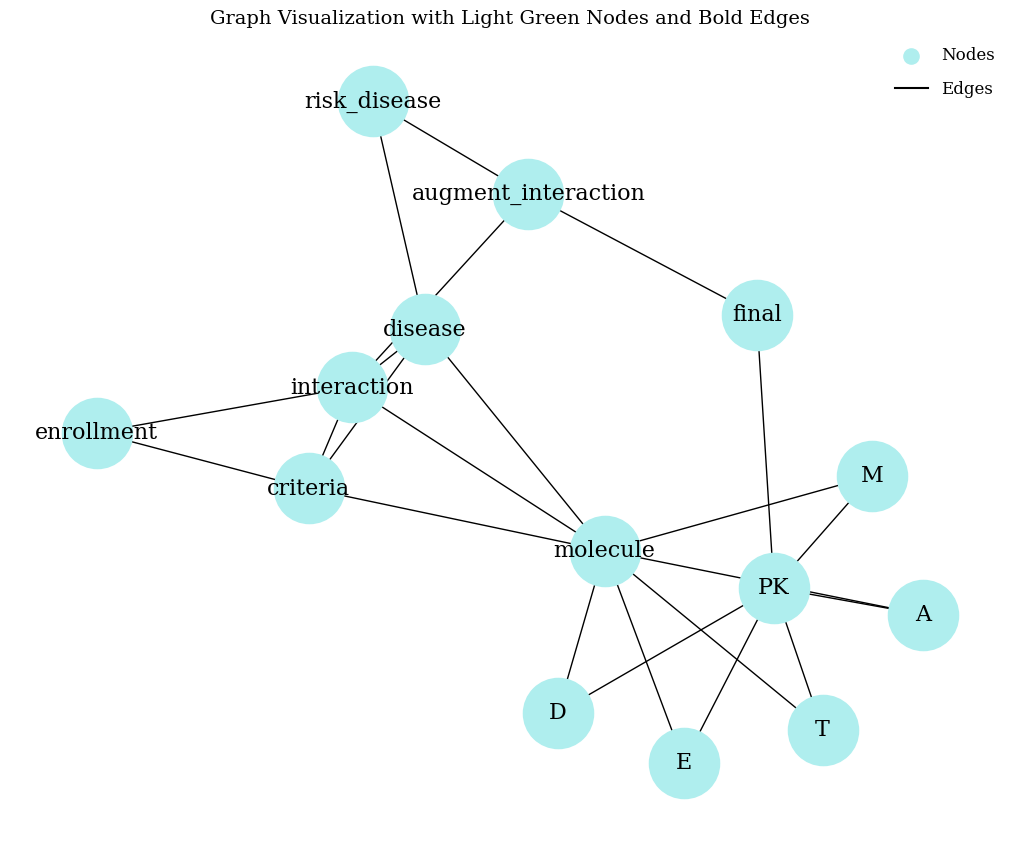

In [24]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib as mpl

def visualize_node_importance(node_importance, data, lst):
    """
    Visualize the graph with node importance highlighted.

    Parameters:
    - node_importance: List of importance scores for each node.
    - data: Object containing edge indices.
    - lst: List of node names or labels.
    """
    # Create graph and add edges
    G = nx.Graph()
    for (u, v) in data.edge_index.cpu().numpy().T:
        G.add_edge(lst[u], lst[v])

    # Add node importance as attribute
    nx.set_node_attributes(G, {lst[i]: importance for i, importance in enumerate(node_importance)}, 'importance')

    # Define positions for nodes
    pos = nx.spring_layout(G, seed=42)  # Fixed layout for consistent visualization

    # Set up node color and size
    node_size = 2500  # Bigger nodes
    node_color = '#afeeee'  # Light green color for nodes

    # Set font to serif (Times New Roman fallback)
    plt.rcParams['font.family'] = 'serif'

    # Draw the graph
    plt.figure(figsize=(10, 8))
    nx.draw(
        G, pos,
        with_labels=True,
        labels={n: n for n in G.nodes()},
        node_color=node_color,
        node_size=node_size,
        font_size=16,  # Bigger font size for annotations
        font_family='serif',  # Ensure node labels use serif font
        edge_color='black',  # Change edges to black for better contrast
        linewidths=1.5,
        font_color='black'
    )

    # Add legend for nodes and edges
    plt.scatter([], [], c='#afeeee', s=120, label='Nodes')
    plt.plot([], [], color='black', linewidth=1.5, label='Edges')
    plt.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='upper right', fontsize=12)

    # Add title
    plt.title("Graph Visualization with Light Green Nodes and Bold Edges", fontsize=14)
    plt.show()

# Example usage
visualize_node_importance(node_importance, data, lst)
# print(node_importance_dict)


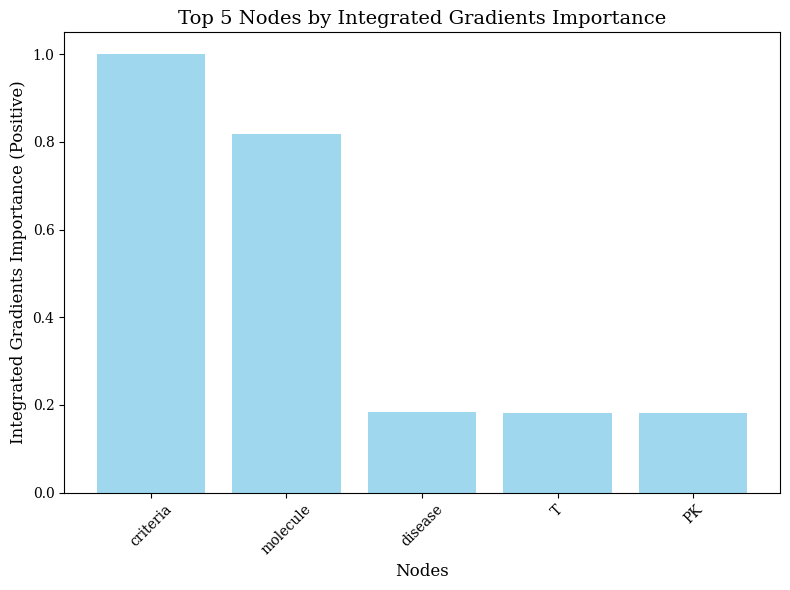

In [25]:
# Extract all node names and their raw importance values
node_names = list(node_importance_dict.keys())
node_importance_values = list(node_importance_dict.values())

# Sort nodes by their absolute importance values in descending order
sorted_indices = np.argsort([abs(value) for value in node_importance_values])[::-1]
sorted_node_names = [node_names[i] for i in sorted_indices][:5]  # Top 5 nodes
sorted_node_importance = [abs(node_importance_values[i]) for i in sorted_indices][:5]  # Top 5 positive values

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(sorted_node_names, sorted_node_importance, color='skyblue', alpha=0.8)
plt.xlabel("Nodes", fontsize=12)
plt.ylabel("Integrated Gradients Importance (Positive)", fontsize=12)
plt.title("Top 5 Nodes by Integrated Gradients Importance", fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()



## GAT

In [26]:
## # Define GAT class
class GAT(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout, alpha, nheads):
        super(GAT, self).__init__()
        self.dropout = dropout
        self.attentions = GATConv(nfeat, nhid, heads=nheads, dropout=dropout)
        self.out_att = GATConv(nhid * nheads, nclass, heads=1, concat=False, dropout=dropout)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.attentions(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.out_att(x, edge_index)
        return x

In [27]:
# PyTorch Geometric Data Object
data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

# Step 5: Define Models
nfeat = data.x.shape[1]
nhid = 32
dropout = 0.6


gat_model = GAT(nfeat=nfeat, nhid=nhid, nclass=1, dropout=dropout, alpha=0.2, nheads=4).to(device)

# Define binary loss and optimizer
optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.01, weight_decay=1e-3)
criterion = torch.nn.BCEWithLogitsLoss()

def train():
    gat_model.train()
    optimizer.zero_grad()
    out = gat_model(data.x, data.edge_index).squeeze()
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    gat_model.eval()
    out = gat_model(data.x, data.edge_index).squeeze()
    pred = (torch.sigmoid(out) > 0.5).long()
    def accuracy(mask):
        return (pred[mask] == data.y[mask]).sum().item() / mask.sum().item()
    return accuracy(data.train_mask), accuracy(data.val_mask), accuracy(data.test_mask)


for epoch in range(200):
    loss = train()
    train_acc, val_acc, test_acc = test()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")

Epoch 0, Loss: 0.5155, Train Acc: 0.5000, Val Acc: 0.5000, Test Acc: 0.0000
Epoch 10, Loss: 0.4664, Train Acc: 0.8333, Val Acc: 1.0000, Test Acc: 1.0000
Epoch 20, Loss: 0.5158, Train Acc: 1.0000, Val Acc: 0.5000, Test Acc: 0.0000
Epoch 30, Loss: 0.3679, Train Acc: 0.8333, Val Acc: 0.5000, Test Acc: 0.5000
Epoch 40, Loss: 0.4188, Train Acc: 1.0000, Val Acc: 0.5000, Test Acc: 0.0000
Epoch 50, Loss: 0.7395, Train Acc: 0.8333, Val Acc: 1.0000, Test Acc: 1.0000
Epoch 60, Loss: 0.3337, Train Acc: 0.8333, Val Acc: 1.0000, Test Acc: 1.0000
Epoch 70, Loss: 0.1587, Train Acc: 0.8333, Val Acc: 1.0000, Test Acc: 1.0000
Epoch 80, Loss: 0.3956, Train Acc: 0.8333, Val Acc: 1.0000, Test Acc: 1.0000
Epoch 90, Loss: 12.7075, Train Acc: 0.8333, Val Acc: 1.0000, Test Acc: 1.0000
Epoch 100, Loss: 0.3178, Train Acc: 0.8333, Val Acc: 1.0000, Test Acc: 1.0000
Epoch 110, Loss: 0.2083, Train Acc: 0.8333, Val Acc: 1.0000, Test Acc: 1.0000
Epoch 120, Loss: 0.2509, Train Acc: 0.8333, Val Acc: 1.0000, Test Acc: 1.0

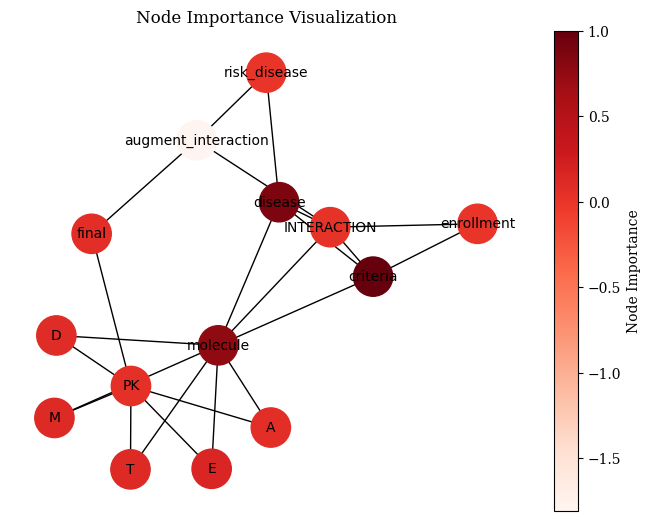

Node Importance Dictionary:
molecule: 0.7689
disease: 0.8710
enrollment: 0.0053
criteria: 1.0000
INTERACTION: 0.0301
risk_disease: 0.0021
augment_interaction: -1.8086
A: 0.0772
D: 0.0925
M: 0.1166
E: 0.1637
T: 0.1182
PK: 0.0479
final: 0.0699


In [28]:
# Define forward function for Captum
def model_forward(node_features, data):
    logits = gat_model(node_features, data.edge_index).squeeze()
    probabilities = torch.stack([1 - torch.sigmoid(logits), torch.sigmoid(logits)], dim=-1)
    return probabilities

# Initialize Integrated Gradients
ig = IntegratedGradients(model_forward)

# Calculate feature importance for each node
attr = ig.attribute(inputs=data.x, target=1, additional_forward_args=(data,), internal_batch_size=data.x.size(0))

# Aggregate feature importances for each node
node_importance = attr.sum(dim=1).cpu().detach().numpy()

# Normalize importance (optional)
if node_importance.max() > 0:
    node_importance = node_importance / node_importance.max()

# Map node indices to meaningful names (example list of node names)
lst = ["molecule", "disease", "enrollment", "criteria", 'INTERACTION', 'risk_disease', 
       'augment_interaction', 'A', 'D', 'M', 'E', 'T', 'PK', "final"]

# Ensure lst length matches the number of nodes
assert len(lst) == data.x.size(0), "Mismatch between node list and number of nodes"

# Create a dictionary of node importance
node_importance_dict = {lst[i]: importance for i, importance in enumerate(node_importance)}

# Visualize node importance
def visualize_node_importance(node_importance, data):
    G = nx.Graph()
    for (u, v) in data.edge_index.cpu().numpy().T:
        G.add_edge(lst[u], lst[v])

    nx.set_node_attributes(G, {lst[i]: importance for i, importance in enumerate(node_importance)}, 'importance')

    pos = nx.spring_layout(G)
    node_colors = [G.nodes[node]['importance'] for node in G.nodes]
    nx.draw(
        G, pos, node_color=node_colors, cmap=plt.cm.Reds,
        with_labels=True, node_size=800, font_size=10
    )
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
    plt.colorbar(sm, label="Node Importance")
    plt.title("Node Importance Visualization")
    plt.show()

# Call visualization function
visualize_node_importance(node_importance, data)

# Print node importance
print("Node Importance Dictionary:")
for node, importance in node_importance_dict.items():
    print(f"{node}: {importance:.4f}")


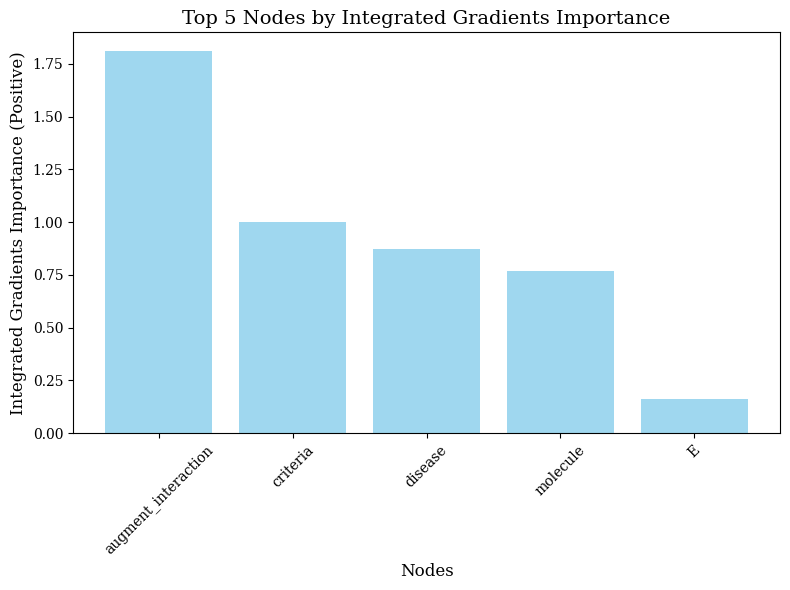

In [29]:
# Extract all node names and their raw importance values
node_names = list(node_importance_dict.keys())
node_importance_values = list(node_importance_dict.values())

# Sort nodes by their absolute importance values in descending order
sorted_indices = np.argsort([abs(value) for value in node_importance_values])[::-1]
sorted_node_names = [node_names[i] for i in sorted_indices][:5]  # Top 5 nodes
sorted_node_importance = [abs(node_importance_values[i]) for i in sorted_indices][:5]  # Top 5 positive values

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(sorted_node_names, sorted_node_importance, color='skyblue', alpha=0.8)
plt.xlabel("Nodes", fontsize=12)
plt.ylabel("Integrated Gradients Importance (Positive)", fontsize=12)
plt.title("Top 5 Nodes by Integrated Gradients Importance", fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()
